In [1]:
import os
import requests
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
def get_ref_url(x: int, y: int) -> str:
    return f"https://khms0.googleapis.com/kh?v=874&hl=en-US&x={x}&y={y}&z=18"

In [3]:
def download_image(url: str, path: str):
    response = requests.get(url)
    if response.status_code != 200:
        return False
    file_name = os.path.basename(path)
    path_name = os.path.dirname(path)
    os.makedirs(path_name, exist_ok=True)
    with open(path, "wb") as f:
        f.write(response.content)
    return True

In [4]:
# double size because of zoom scale
# the google images at 256 are about double the scale of the updated tiles
def double_size(target_img):
    double = target_img.size[0] * 2
    img = target_img.resize((double, double), Image.ANTIALIAS)
    return img

In [5]:
def get_ref_tile(x: int, y: int):
    ref_url = get_ref_url(x, y)
    image_path = f"google/{x}/{y}.jpg"
    if not os.path.exists(image_path):
        success = download_image(ref_url, image_path)
        if success is False:
            return np.empty(0)
    target_img = Image.open(image_path)
    target_img = double_size(target_img)
    return np.array(target_img)

(512, 512, 3)
(512, 512)


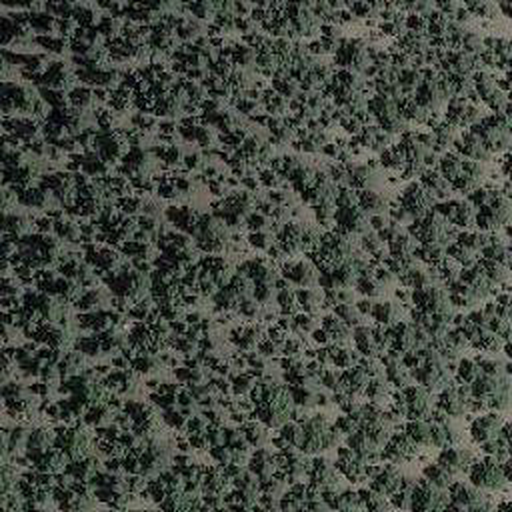

In [6]:
# get our first target google tile and double it
# here is a known parachute tile
# https://9mile.xcskies.com/?lat=39.080160493909055&lon=-116.33046962292114&source=aug27_dg_color_a1
example_target = get_ref_tile(x=46362, y=100110)
print(example_target.shape)
example_target_img = Image.fromarray(example_target, 'RGB')
print(example_target_img.size)
example_target_img

In [7]:
def get_target_url(x: int, y: int) -> str:
    # y is reverse, so +1 to go up -1 goes down
    # x is +1 to go right
    return f"http://3.235.235.188/tiles/rgb_aug27_p2/19/{x}/{y}.png"

In [8]:
# x=46362, y=100110
# get the 3 x 3 grid of offset images that match the approximate 2x2 tiles of the google tile
def get_nine_patch(x: int, y: int):
    # origin of a known tile
    ox = x - 46362
    oy = y - 100110
    # the target tiles are at this known origin with 2x the smaller tiles from this origin
    tx = 92724 + (ox * 2)
    ty = 324067 + (oy * 2)
    # then we want all 9 tiles in a 3x3 due to overlap
    org_size = 256
    patch_image = np.empty((org_size * 3, org_size * 3, 3), dtype=np.uint8)
    for i in range(0, 3):
        for j in range(0, 3):
            # -j because we need to subtract y
            new_x = tx+i
            new_y = ty-j
            url = get_target_url(x=new_x, y=new_y)
            img_path = f"search/{new_x}/{new_y}.png"
            if not os.path.exists(img_path):
                success = download_image(url, img_path)
                if not success:
                    return False
            target_img = Image.open(img_path).convert("RGB")
            target_np = np.array(target_img)
            x_offset = j*org_size
            y_offset = i*org_size
            patch_image[x_offset:x_offset+org_size, y_offset:y_offset+org_size] = target_np
            
    return patch_image

(768, 768)


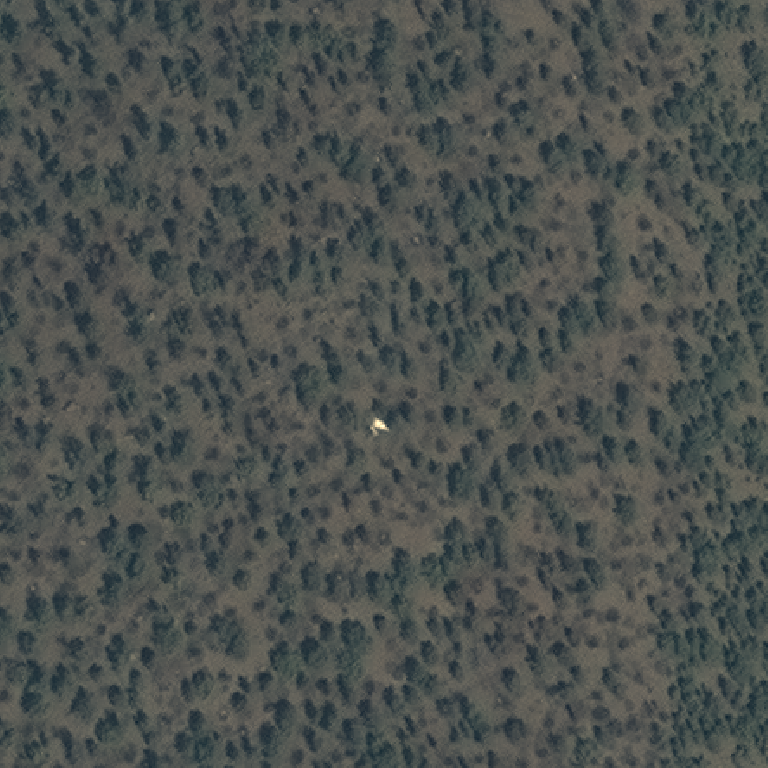

In [9]:
patch_image = get_nine_patch(x=46362, y=100110)
img = Image.fromarray(patch_image, 'RGB')
# 3 x 3 of the 256 tiles around the same position as above
print(img.size)
img

In [10]:
# tiles are offset by approximately: x +27 y +12 where the google target is slightly inside

(512, 512, 3)
(768, 768, 3)


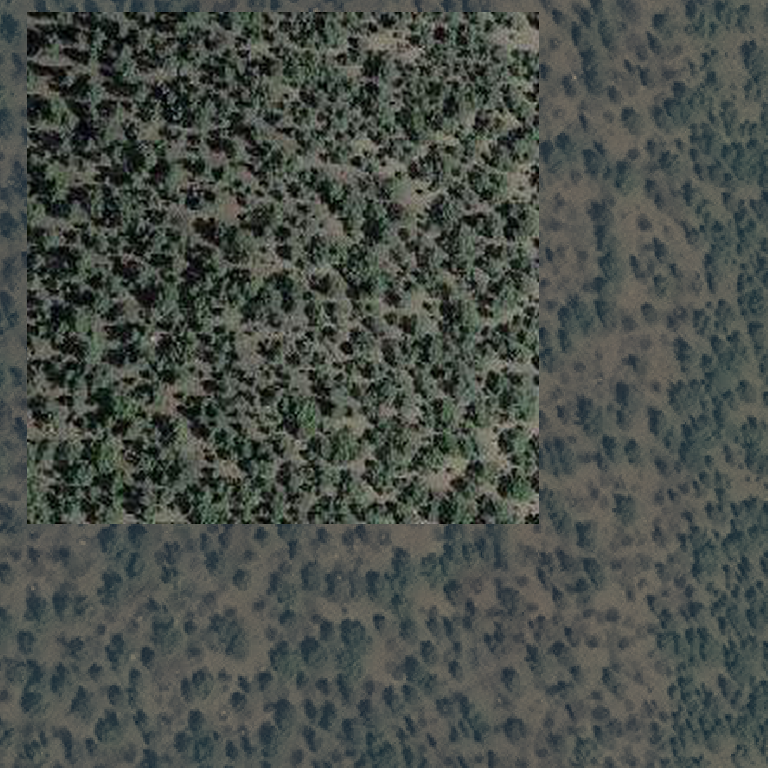

In [11]:
# show the overlay, note the image looks slightly wrong due to the change in shadow position
overlay = patch_image.copy()
overlay_x_offset = 27
overlay_y_offset = 12
print(example_target.shape)
print(overlay.shape)
copy_y = example_target.shape[0] + overlay_y_offset
copy_x = example_target.shape[1] + overlay_x_offset
overlay[overlay_y_offset:copy_y, overlay_x_offset:copy_x] = example_target
overlay_img = Image.fromarray(overlay, 'RGB')
overlay_img

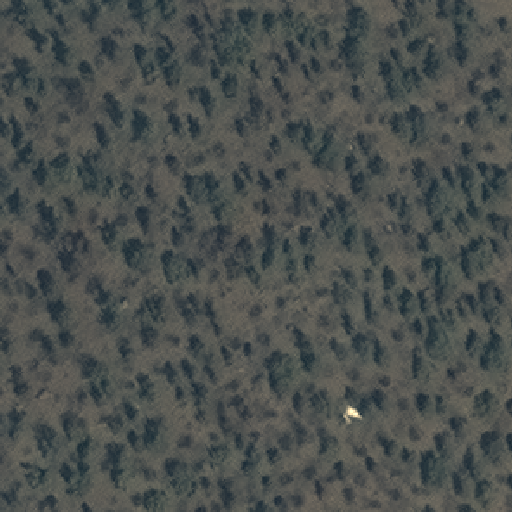

In [12]:
# copy only the same 512x512 region of pixels as the google reference image
match = np.empty(example_target.shape)
overlay_x_offset = 27
overlay_y_offset = 12
copy_y = match.shape[0] + overlay_y_offset
copy_x = match.shape[1] + overlay_x_offset
match = patch_image[overlay_y_offset:copy_y, overlay_x_offset:copy_x]
match_img = Image.fromarray(match, 'RGB')
match_img

In [13]:
def get_tile_pair(x: int, y: int):
    example_target = get_ref_tile(x=x, y=y)
    patch_image = get_nine_patch(x=x, y=y)
    if type(patch_image) == bool and patch_image is False:
        return False, False
    match = np.empty(example_target.shape)
    overlay_x_offset = 27
    overlay_y_offset = 12
    copy_y = match.shape[0] + overlay_y_offset
    copy_x = match.shape[1] + overlay_x_offset
    match = patch_image[overlay_y_offset:copy_y, overlay_x_offset:copy_x]
    return example_target, match

<PIL.Image.Image image mode=RGBA size=512x512 at 0x12ABEE580> <PIL.Image.Image image mode=RGBA size=512x512 at 0x12ABEEA00>


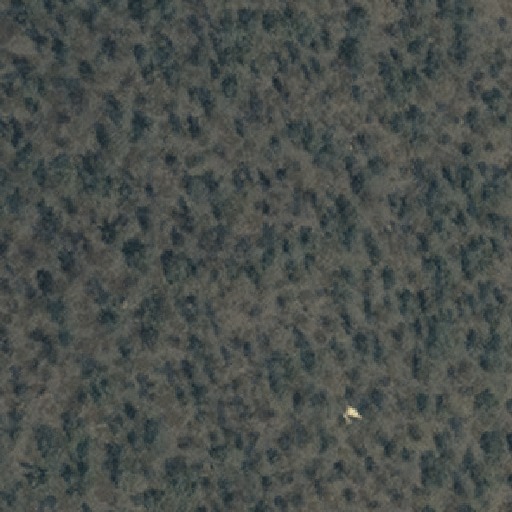

In [14]:
# show the images overlaid with opacity
im1 = Image.fromarray(match, 'RGB')
im1.putalpha(255)
im2 = Image.fromarray(example_target, 'RGB')
im2.putalpha(50)
print(im1, im2)
comp = Image.alpha_composite(im1, im2)
comp

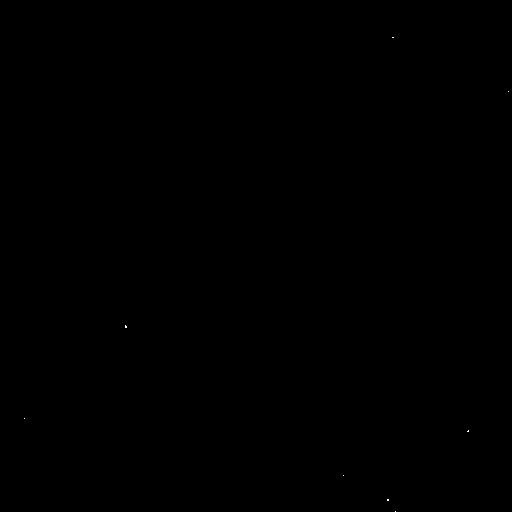

In [15]:
grey_target = cv2.cvtColor(example_target, cv2.COLOR_RGB2GRAY)
ret, target_mask = cv2.threshold(grey_target, 160, 255, cv2.THRESH_BINARY)
Image.fromarray(target_mask)

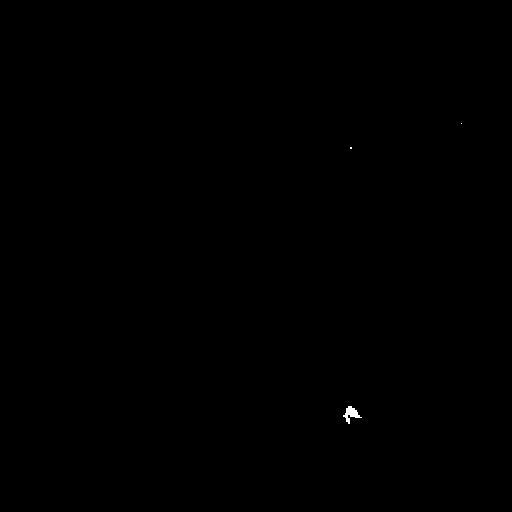

In [16]:
grey_match = cv2.cvtColor(match, cv2.COLOR_RGB2GRAY)
ret, match_mask = cv2.threshold(grey_match, 127, 255, cv2.THRESH_BINARY)
Image.fromarray(match_mask)

In [17]:
def thresh_images(target_img1, match_img2):
    grey_target = cv2.cvtColor(target_img1, cv2.COLOR_RGB2GRAY)
    # google reference is darker so higher threshold
    ret, target_mask = cv2.threshold(grey_target, 160, 255, cv2.THRESH_BINARY)
    grey_match = cv2.cvtColor(match_img2, cv2.COLOR_RGB2GRAY)
    ret, match_mask = cv2.threshold(grey_match, 127, 255, cv2.THRESH_BINARY)
    return target_mask, match_mask

In [18]:
diff = match_mask - target_mask

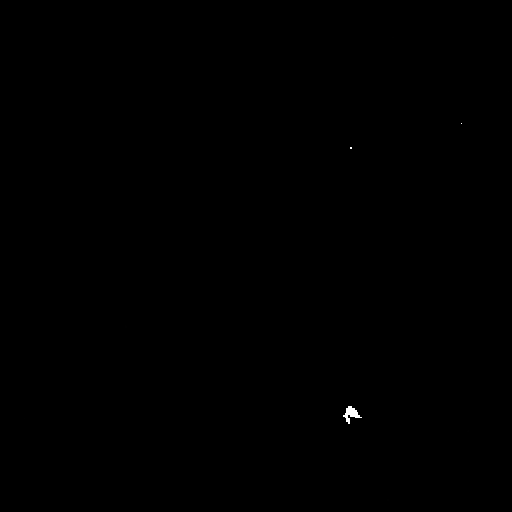

In [19]:
diff_img = Image.fromarray(diff)
diff_img

In [20]:
# run
def check_patch(x: int, y: int):
    target, match = get_tile_pair(x=x, y=y)
    if target is False:
        print("Skipping")
        return np.empty(0), np.empty(0), np.empty(0)
    target_tresh, match_tresh = thresh_images(target, match)
    diff = match_tresh - target_tresh
    count = np.sum(diff)
    print("count", count)
    if count > 10000:
        print("Found something @ ", x, y)
    return Image.fromarray(diff), Image.fromarray(match), Image.fromarray(target)

count 38523
Found something @  46362 100110


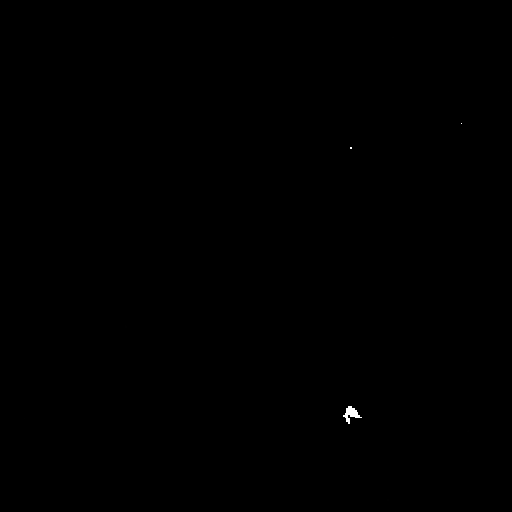

In [21]:
# this is a known parachute region
diff, match, target = check_patch(x=46362, y=100110)
diff

In [22]:
# available image range for this set is:
#  x 92599 - 92889
#  y 323972 - 324387
# top left:
# http://3.235.235.188/tiles/rgb_aug27_p2/19/92599/323972.png

# bottom right:
# http://3.235.235.188/tiles/rgb_aug27_p2/19/92889/324387.png


def get_google_coords(tx, ty):
    gox = 46362
    goy = 100110

    diff_x = (tx - 92724) // 2
    diff_y = (ty - 324067) // 2
    return (gox + diff_x), (goy + diff_y)

In [ ]:
# for i in range(92599, 92890):
#     for j in range(323972, 323973):

for i in range(92660, 92890):
    for j in range(324072, 324388):
        coords = get_google_coords(i, j)
        print(coords)
        try:
            diff, match, target = check_patch(x=coords[0], y=coords[1])
            plt.imshow(diff)
            plt.show()
            plt.imshow(match)
            plt.show()

        except Exception as e:
            print("error: ", e)